# Characterizing and Predicting Dog Adoption Rates

## Intro
I am using data sets I obtained from Kaggle: [dog breeds parameters scraped from at dogtime.com](https://www.kaggle.com/hocop1/cat-and-dog-breeds-parameters) and the Austin Animal Center's [intake and outake records.](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/) . 

The Austin Animal Center data describes the animals that the shelter accepts (from various places) and the dates the animal enter and leave the shelter. The time in the shelter is an important metric: it directly affects the cost of keeping the animal, and the ideal would be to have animals adopted out in a timely manner. 

I will import several python modules, load the AAC data, and clean it. I will then load a dataset of dog breed descriptions, and replace the 'breed' features, which has hundreds of breeds listed, with the breed description variables from this second data set. This will allow the use of a very descriptive feature, without expanding it into hundreds of binary features. I will then eliminate any unhelpful features, and mode the data with several machine learning models to try to estimate the time a dog will spend in the shelter.

## Setup

In [288]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from boruta import BorutaPy
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler

#models
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

#model selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [289]:
#I will need to inspect a lot of data
pd.set_option('display.max_columns', 500)
pd.set_option('max_rows', 100)

# Shelter Dataset: Exploration and Cleaning

I will start with the dataset recording all animals kept by the Austin shelter.

In [290]:
raw = pd.read_csv(r'aac_intakes_outcomes.csv')  # I will used the merged file with both intake records and outcome records
shelter_inout_df = raw.copy(deep=True)

In [291]:
shelter_inout_df.animal_type.unique()

array(['Dog', 'Cat', 'Other', 'Bird'], dtype=object)

In [292]:
#we are only looking at dogs
shelter_inout_df = shelter_inout_df[shelter_inout_df.animal_type == 'Dog']

There are a lot of features that i'm not interested, especially that describe the same thing in multiple ways.  
I am using time in shelter as it is a simple scalar, not d datetime.  
Count is only 1, no other values exist

In [293]:
shelter_inout_df = shelter_inout_df.drop(columns=['animal_type', "age_upon_outcome", "animal_id_outcome", "age_upon_outcome_(years)", 
                                                  'age_upon_outcome_(days)', "age_upon_outcome_age_group", "outcome_year", 
                                                  "outcome_monthyear", "outcome_hour", "outcome_number", "animal_id_intake", 
                                                  "age_upon_intake_(years)", "age_upon_intake_age_group", "intake_year", 
                                                  "intake_monthyear", "intake_hour", "intake_number", "time_in_shelter", 
                                                  "found_location", 'outcome_datetime', 'dob_year', 'dob_month', 'dob_monthyear',
                                                  'outcome_month', 'outcome_weekday', 'age_upon_intake', 'intake_month',
                                                  'date_of_birth', 'count'])
shelter_inout_df.shape

(45366, 12)

In [294]:
#look for missing data
shelter_inout_df.isna().sum()

outcome_subtype           31598
outcome_type                  2
sex_upon_outcome              1
breed                         0
color                         0
intake_condition              0
intake_type                   0
sex_upon_intake               1
age_upon_intake_(days)        0
intake_datetime               0
intake_weekday                0
time_in_shelter_days          0
dtype: int64

Outcome and sex related fields are the only source of nulls (at this point).

### Outcome

In [295]:
#review which outcomes have which subtypes
outcome_pivot = shelter_inout_df[['outcome_type', 'outcome_subtype']].pivot_table(index='outcome_type', 
                                                                                  columns='outcome_subtype', aggfunc=len)
outcome_pivot

outcome_subtype,Aggressive,At Vet,Barn,Behavior,Court/Investigation,Enroute,Foster,In Foster,In Kennel,In Surgery,Medical,Offsite,Partner,Possible Theft,Rabies Risk,Suffering
outcome_type,,,,,,,,,,,,,,,,
Adoption,NaN,NaN,NaN,NaN,NaN,NaN,2174.0,NaN,NaN,NaN,NaN,254.0,NaN,NaN,NaN,NaN
Died,NaN,15.0,NaN,NaN,NaN,5.0,NaN,18.0,89.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
Euthanasia,492.0,12.0,NaN,133.0,23.0,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,86.0,690.0
Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN
Return to Owner,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transfer,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9696.0,NaN,NaN,NaN


In [296]:
shelter_inout_df[['outcome_type', 'outcome_subtype']].isna().sum()

outcome_type           2
outcome_subtype    31598
dtype: int64

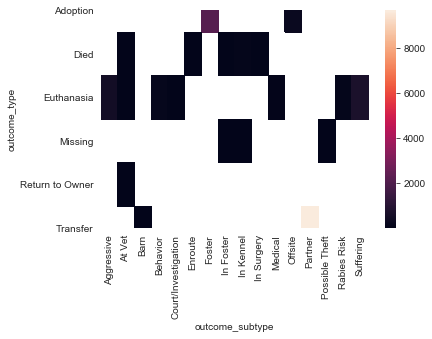

In [297]:
sns.set_style("whitegrid")
sns.heatmap(outcome_pivot);

This only contains information that is known once the animal leaves the shelter, and so can't be used to predict the time in the shelter. We might want to attempt to predict this as part of an extension of this project. However, given the amount of missing data in these fields, we will choose to focus on the time_in_shelter_days field as the target.

In [298]:
#can't be used to predict
shelter_inout_df.drop(columns=["outcome_subtype"], inplace=True)

### Color 
We want to use color as a set of features. There are multiple colors listed in a text field for each animal so they need to be split and each color encoded as a variable. There will be multiple colors for some animal.

In [299]:
#take a look at some of the colors listed.
shelter_inout_df.color.head()

0    Yellow/White
1    Yellow/White
2    Yellow/White
3        Tricolor
4     Brown/White
Name: color, dtype: object

In [300]:
#split color data into 2 fields
shelter_inout_df["color1"] = ""  #creating empty columns to avoid errors when assigning to multiple columns before they are created
shelter_inout_df["color2"] = ""
shelter_inout_df["color1"] = shelter_inout_df["color"].str.split(pat="/", expand=True)[0]
shelter_inout_df["color2"] = shelter_inout_df["color"].str.split(pat="/", expand=True)[1]

In [301]:
#Remove color descriptors to reduce number of colors and create new feature
shelter_inout_df["color_type"] = shelter_inout_df.color1.str.split(expand=True)[1]
shelter_inout_df["color1"] = shelter_inout_df.color1.str.split(expand=True)[0]
shelter_inout_df["color_type2"] = shelter_inout_df.color2.str.split(expand=True)[1]
shelter_inout_df["color2"] = shelter_inout_df.color2.str.split(expand=True)[0]

In [302]:
shelter_inout_df.color_type.unique()

array([None, 'Merle', 'Brindle', 'Tick', 'Tiger', 'Smoke', 'Cream'],
      dtype=object)

In [303]:
shelter_inout_df.color_type2.unique()

array([None, 'Brindle', 'Merle', 'Tick', 'Tiger', 'Cream', 'Tabby',
       'Smoke'], dtype=object)

In [304]:
#Investigate how many categories this variable has
pd.concat([shelter_inout_df.color1, shelter_inout_df.color2], 0).value_counts()

White        24186
Black        15704
Brown        11776
Tan           9255
Red           2623
Blue          2559
Tricolor      2454
Chocolate     1309
Gray           855
Cream          850
Sable          745
Yellow         744
Buff           666
Fawn           590
Gold           203
Silver         174
Apricot         76
Liver           72
Orange          40
Pink             4
Agouti           4
Ruddy            1
Tortie           1
dtype: int64

I want to put values from both color fields into same set of dummy fields.

In [305]:
#One hot encode both and create list of colors so colors from both sources can be combined.
color_df = pd.get_dummies(shelter_inout_df[["color1", "color2"]], drop_first=True)
color_list = pd.Series(color_df.columns.values)
color_list = pd.concat([color_list, color_list.str.split(pat='_', expand=True)], axis=1)
color_list.columns = ['fullname', 'source', 'colorname']

In [306]:
#Add results from both fields into new single field
for color in color_list["colorname"].unique():
    shelter_inout_df[color] = 0
    shelter_inout_df.loc[(shelter_inout_df["color1"]==color) | (shelter_inout_df["color2"]==color),color] = 1
shelter_inout_df = shelter_inout_df.drop(columns=['color', 'color1', 'color2'])    

# Import Dataset: Dog Breed Descriptions
I would like to replace the very descriptive, but high dimension category 'breed' with a limited set of continuous numerical descriptions.
### Explore this data

In [307]:
with open('rating.json', 'r') as rating_file:
    ratings = json.load(rating_file)
    json_normalize(ratings)
    dog_descr_df = pd.DataFrame.from_dict(ratings['dog_breeds'], ).T
dog_descr_df.head()

,Adaptability,All Around Friendliness,Exercise Needs,Health Grooming,Trainability,Adapts Well to Apartment Living,Affectionate with Family,Amount Of Shedding,Dog Friendly,Drooling Potential,Easy To Groom,Easy To Train,Energy Level,Exercise Needs,Friendly Toward Strangers,General Health,Good For Novice Owners,Incredibly Kid Friendly Dogs,Intelligence,Intensity,Potential For Mouthiness,Potential For Playfulness,Potential For Weight Gain,Prey Drive,Sensitivity Level,Size,Tendency To Bark Or Howl,Tolerates Being Alone,Tolerates Cold Weather,Tolerates Hot Weather,Wanderlust Potential
Affenpinscher,3.0,3.0,4.0,2.0,3.0,5.0,5.0,1.0,4.0,1.0,3.0,2.0,4.0,3.0,3.0,4.0,4.0,1.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,1.0,2.0,1.0,3.0,3.0,2.0
Afghan Hound,4.0,4.0,4.0,2.0,3.0,5.0,5.0,4.0,4.0,1.0,1.0,1.0,5.0,4.0,2.0,3.0,3.0,5.0,4.0,2.0,3.0,4.0,1.0,5.0,5.0,4.0,2.0,2.0,5.0,5.0,5.0
Airedale Terrier,2.0,4.0,5.0,3.0,5.0,1.0,4.0,2.0,4.0,1.0,2.0,4.0,5.0,5.0,3.0,3.0,2.0,4.0,5.0,3.0,5.0,5.0,4.0,5.0,3.0,3.0,4.0,2.0,3.0,3.0,4.0
Akita,3.0,2.0,4.0,4.0,4.0,2.0,5.0,5.0,1.0,5.0,1.0,2.0,4.0,4.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,4.0,4.0,5.0,4.0,5.0,1.0,5.0,2.0,4.0
Alaskan Klee Kai,3.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,2.0,2.0,4.0,4.0,4.0,4.0,2.0,4.0,2.0,3.0,4.0,2.0,2.0,4.0,2.0,5.0,4.0,2.0,3.0,2.0,5.0,2.0,4.0


In [308]:
# Make columns easier to reference in code
dog_descr_df.columns = dog_descr_df.columns.str.strip()
dog_descr_df.columns = dog_descr_df.columns.str.replace(" ", "_")

In [309]:
dog_descr_df.describe()

,Adaptability,All_Around_Friendliness,Exercise_Needs,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Dog_Friendly,Drooling_Potential,Easy_To_Groom,Easy_To_Train,Energy_Level,Exercise_Needs,Friendly_Toward_Strangers,General_Health,Good_For_Novice_Owners,Incredibly_Kid_Friendly_Dogs,Intelligence,Intensity,Potential_For_Mouthiness,Potential_For_Playfulness,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,3.116822,4.070093,4.107477,2.995327,3.560748,3.074766,4.700935,3.014019,3.551402,1.705607,3.350467,3.560748,4.093458,4.079439,3.420561,3.425234,2.864486,4.112150,4.070093,3.336449,3.126168,4.364486,3.294393,3.593458,3.892523,2.841121,3.121495,2.037383,3.331776,3.074766,3.443925
std,0.565351,0.827771,0.818013,0.601232,0.623146,1.575642,0.560264,1.231355,1.227491,1.215034,1.418713,1.147993,0.949749,0.996825,1.191026,1.039826,1.208480,1.068781,0.731416,1.095822,1.006070,0.803660,0.950545,1.201780,0.818013,1.155916,1.227313,0.953622,1.209206,0.941490,1.208008
min,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,4.000000,4.000000,3.000000,3.000000,1.000000,4.000000,2.000000,3.000000,1.000000,2.000000,3.000000,4.000000,3.000000,3.000000,3.000000,2.000000,4.000000,4.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000
50%,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,5.000000,3.000000,4.000000,1.000000,3.500000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,5.000000,3.000000,4.000000,4.000000,3.000000,3.000000,2.000000,4.000000,3.000000,4.000000
75%,3.000000,5.000000,5.000000,3.000000,4.000000,5.000000,5.000000,4.000000,5.000000,2.000000,5.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000
max,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


This data is continuous and seems to be a 1-5 scale, though they seem to be optimistically valenced.

### Exercise Need - Duplicate

In [310]:
dog_descr_df.Exercise_Needs.head()

,Exercise_Needs,Exercise_Needs
Affenpinscher,4.0,3.0
Afghan Hound,4.0,4.0
Airedale Terrier,5.0,5.0
Akita,4.0,4.0
Alaskan Klee Kai,4.0,4.0


In [311]:
# Combine two features with same name but different value into one feature
exercise_need_cols = dog_descr_df.columns.get_loc("Exercise_Needs").nonzero()  #get column numbers since name reference causes errors
dog_descr_df["Exercise_Need"] = (dog_descr_df.iloc[:,[exercise_need_cols[0][0]]] + \
                                 dog_descr_df.iloc[:,[exercise_need_cols[0][1]]])/2
dog_descr_df = dog_descr_df.drop(columns=["Exercise_Needs"])  # New col is not plural
dog_descr_df.loc[:,dog_descr_df.columns.str.contains("Exer*")].head()

,Exercise_Need
Affenpinscher,3.5
Afghan Hound,4.0
Airedale Terrier,5.0
Akita,4.0
Alaskan Klee Kai,4.0


### Look for Nulls

In [312]:
dog_descr_df[dog_descr_df.isna().any(axis=1)]

,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Dog_Friendly,Drooling_Potential,Easy_To_Groom,Easy_To_Train,Energy_Level,Friendly_Toward_Strangers,General_Health,Good_For_Novice_Owners,Incredibly_Kid_Friendly_Dogs,Intelligence,Intensity,Potential_For_Mouthiness,Potential_For_Playfulness,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential,Exercise_Need
Korean Jindo Dog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Xoloitzcuintli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [313]:
# two rows of just null. These add zero information for these breeds.
dog_descr_df = dog_descr_df.dropna(axis=0)

# Initial Feature Selection
Before merging these feature into the main dataframe, lets make sure they will all be helpful; highly correlated features won't add anything after the first one.

In [314]:
dog_desc_corr_df = dog_descr_df.corr()

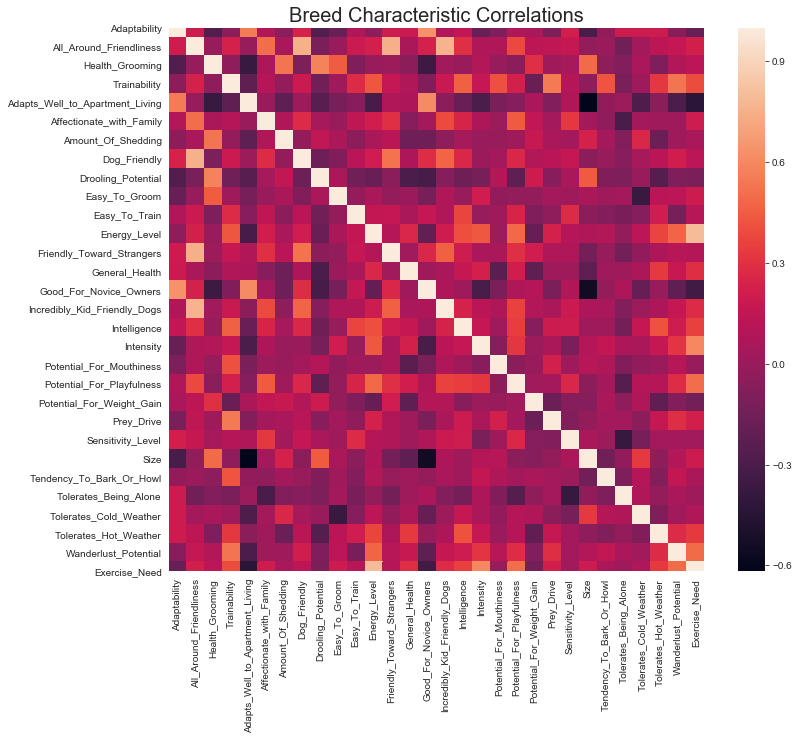

In [319]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,10))
sns.heatmap(dog_desc_corr_df)
plt.title("Breed Characteristic Correlations", fontsize=20);

In [320]:
#id and remove highly correlated traits to avoid multicolinearity issues in linear reg. models and reduce compute time
dog_high_corr = dog_desc_corr_df[(dog_desc_corr_df.abs() > .65) & ~(dog_desc_corr_df == 1)]
for i, row in dog_high_corr.iterrows():
    if row.sum() > 0: 
        print("{} is correlated with: ".format(i), end = '') 
        for ind, col in row.iteritems():
            if ~np.isnan(col):
                print("{} at {}".format(ind, col))
        print("\n")


All_Around_Friendliness is correlated with: Dog_Friendly at 0.7565146009482395
Friendly_Toward_Strangers at 0.7509267951607245
Incredibly_Kid_Friendly_Dogs at 0.7605389789255196


Dog_Friendly is correlated with: All_Around_Friendliness at 0.7565146009482395


Energy_Level is correlated with: Exercise_Need at 0.8029938934844397


Friendly_Toward_Strangers is correlated with: All_Around_Friendliness at 0.7509267951607245


Incredibly_Kid_Friendly_Dogs is correlated with: All_Around_Friendliness at 0.7605389789255196


Exercise_Need is correlated with: Energy_Level at 0.8029938934844397




In [321]:
#These are highly correlated.
dog_descr_df = dog_descr_df.drop(columns=["Friendly_Toward_Strangers", "Incredibly_Kid_Friendly_Dogs", "Dog_Friendly", "Intensity",
                                         "Exercise_Need"])

## Feature Augmentation - Combining datasets

I will merge the two datasets, but this requires significant cleaning of the breed name fields to ensure I can bring as much information to each record.

In [322]:
#Largest percentage breeds
100* shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()/shelter_inout_df.shape[0]

Pit Bull Mix                 13.790063
Chihuahua Shorthair Mix      10.648944
Labrador Retriever Mix       10.556364
German Shepherd Mix           4.298373
Australian Cattle Dog Mix     2.422519
Name: breed, dtype: float64

### Breed Field Cleaning
The breed field from the shelter data has a lot of mixes and multiple breeds listed. Let's clean that.

In [323]:
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()
#Breed name shouldn't include slash since that is the breed delimiter
shelter_inout_df.breed = shelter_inout_df.breed.str.replace(r'Black/Tan', 'Black and Tan', regex=False)
shelter_inout_df.breed = shelter_inout_df.breed.str.replace(r'(Miniature |Toy |Standard )?Poodle(?=(?:$)|[$\n \/])', 'Poodle',
                                                            regex=True) 

In [324]:
def replace_abbr(col, old, new, avoid):
    '''regex will: (1)match old, (2)then nl space or slash, (3)but not 'avoid'. Func returns cleaned column.'''
    search_string = r'{}(?=(?:$)|[\n \/])(?!{})'.format(old, avoid) 
    new_col = col.str.replace(search_string, new, regex=True)
    return new_col

In [325]:
# define breed name changes - Need to match breed in shelter records
breed_abbr_fixes = [['Terr', 'Terrier', 'ier'],  # added 'ier' to avoid null in lookahead. ?
                   ['Eng', 'English', ''],
                   ['Port', 'Portuguese', ''],
                   ['Span', 'Spaniel', ''],
                   ['Pinsch', 'Pinscher', 'er'],  #null in neg lookahead seems to cause problem without 'er'
                   ['Catahoula', 'Catahoula Leopard Dog', ' Leopard Dog'],
                   ['Rhod', 'Rhodesian', 'Rhod'],
                   ['Pit Bull', 'American Pit Bull Terrier', ' Terrier'],
                   ['Anatol Shepherd', 'Anatolian Shepherd Dog', ' Dog'],
                   ['German Shepherd', 'German Shepherd Dog', ' Dog'],
                   ['Black and Tan Hound', 'Black and Tan Coonhound', 'Coon']]
for i in breed_abbr_fixes:
    uncorrected, corrected, avoid = i
    shelter_inout_df.breed = replace_abbr(shelter_inout_df.breed, uncorrected, corrected, avoid)

In [326]:
#check breeds now in dataset
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

American Pit Bull Terrier Mix    6425
Chihuahua Shorthair Mix          4831
Labrador Retriever Mix           4789
German Shepherd Dog Mix          1950
Australian Cattle Dog Mix        1099
Name: breed, dtype: int64

In [327]:
def pull_cat_out(df, colname, category):
    '''Func to remove some common descriptors and create separate features from them'''
    df[category] = df[colname].str.contains(r'{}'.format(category), regex=True).astype(int)      
    df[colname] = df[colname].str.replace(r'{}'.format(category), '', regex=True)
    return df

In [328]:
#list common breed descriptors and remove
breed_cats = ['Shorthair', 'Longhair', 'Wirehair', 'Rough Coat', 'Mix']
for cat_i in breed_cats:
    shelter_inout_df = pull_cat_out(shelter_inout_df, "breed", cat_i)

In [329]:
#reorder columns so I can see column I am using a lot
shelter_inout_df = shelter_inout_df.reindex(columns=(['breed'] + list([a for a in shelter_inout_df.columns if a != 'breed']) ))

In [330]:
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()

In [331]:
# get breed names x & y for 'x y mix'
shelter_inout_df[["breed", "breed2"]] = shelter_inout_df.breed.str.split(pat="/", expand=True, n=1)

In [332]:
# run again after replacing names
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()
shelter_inout_df.breed2 = shelter_inout_df.breed2.str.strip()

In [333]:
#Code used for finding common mismatches to add to code above
dog_descr_df.index.names = ['breed']  
shelter_dog_list_df = pd.DataFrame(pd.concat([shelter_inout_df.breed, shelter_inout_df.breed2], axis=0) \
                                   ).rename(columns={0:"breed"})
shelter_breed_list_df = pd.merge(left=shelter_dog_list_df, right=dog_descr_df, left_on='breed', right_on="breed", indicator=True,
                                  how='outer')
shelter_only_breeds_df = shelter_breed_list_df[shelter_breed_list_df._merge == 'left_only']
shelter_only_breeds_df["breed"].value_counts().sort_values(ascending=False).head()

Staffordshire        453
Plott Hound          388
Chinese Sharpei      236
Queensland Heeler    210
English Bulldog      131
Name: breed, dtype: int64

In [334]:
#Find breed names with multiple matches - just the Black/Tan. fixed in cell above now.
#NotNeeded shelter_inout_df[shelter_inout_df.breed.str.contains("/[\w\s]+/", regex=True)]["breed"]

I have most of the records identified to dog breeds that are in the dog breed description dataset. Most of the remaining most common dog breeds are not in the set or are ambiguous (eg there are two breeds know as 'Staffordshire'.)

### Combine DFs

In [335]:
#merge dataframes on cleaned breed columns
shelter_inout_wbreeds_df = pd.merge(left=shelter_inout_df, right=dog_descr_df, left_on="breed", right_index=True, how='left')

## Deal with issues created by merge.

In [336]:
#Create feature to identify that the description information isn't reliable.
shelter_inout_wbreeds_df["no_breed_info"] = shelter_inout_wbreeds_df["Affectionate_with_Family"].isna().astype('int')

#### Average breed data for animals with two breeds listed.

In [337]:
#get data fields for breed2
field_list = dog_descr_df.columns.to_list()
shelter_inout_wbreeds_df = pd.merge(left=shelter_inout_wbreeds_df, right=dog_descr_df, left_on="breed2", right_index=True, 
                                    how='left', suffixes=('','_b2'))

In [338]:
shelter_inout_wbreeds_df["no_breed_info2"] = shelter_inout_wbreeds_df["Affectionate_with_Family_b2"].isna().astype('int')

In [339]:
# For rows with breed info in both sets, get averages.
shelter_inout_wbreeds_df["no_breed_info_total"] = shelter_inout_wbreeds_df["no_breed_info"] + shelter_inout_wbreeds_df["no_breed_info2"]
field_list_b2 = []
for field in field_list:
    shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["no_breed_info_total"] == 0, field] = \
    (shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["no_breed_info_total"] == 0, field] +
    shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["no_breed_info_total"] == 0, (field + "_b2")] )/2
    field_list_b2.append(field + "_b2")


In [340]:
#for rows with only breed2 info, use that.
shelter_inout_wbreeds_df["only_breed2_info"] = shelter_inout_wbreeds_df["no_breed_info"] > shelter_inout_wbreeds_df["no_breed_info2"]
for field in field_list:
    shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["only_breed2_info"] == 0, field] = \
    shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["only_breed2_info"] == 0, (field + "_b2")] 
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.drop(columns=field_list_b2)    

In [341]:
# drop columns except field that indicates breed desc fields were imputed
shelter_inout_wbreeds_df.drop(columns=["only_breed2_info", "no_breed_info", 'breed', 'breed2'], inplace=True)
shelter_inout_wbreeds_df["no_breed_info_total"] = shelter_inout_wbreeds_df.no_breed_info_total.replace(1,0)

#### Nulls
I already know that there are no nulls in the dog description DF, so nulls in any column from that df be because of there not being a match on the breed name. Any record with a null in one of those fields will have nulls in all of those fields.  
Since these nulls are all from the same breed, FancyImpute doesn't have any breed info to work on and I will just use feature means.

In [342]:
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df.Adaptability.notna()].shape

(6417, 65)

In [343]:
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df.Adaptability.isna()].shape

(38949, 65)

In [344]:
#fill nulls created because breed was not found in breed desc, with column mean
for colname, col in dog_descr_df.iteritems():
    shelter_inout_wbreeds_df.loc[:,colname] = shelter_inout_wbreeds_df[[colname]].fillna(shelter_inout_wbreeds_df[colname].mean(), 
                                                                                         axis=1)

### Intake Features

In [346]:
shelter_inout_wbreeds_df[['intake_condition', 'intake_type']].pivot_table(columns="intake_condition", 
                                                                           index='intake_type', aggfunc=len)

intake_condition,Aged,Feral,Injured,Normal,Nursing,Other,Pregnant,Sick
intake_type,,,,,,,,
Euthanasia Request,34.0,NaN,10.0,74.0,NaN,1.0,NaN,63.0
Owner Surrender,56.0,NaN,189.0,8267.0,90.0,9.0,4.0,309.0
Public Assist,18.0,NaN,91.0,3891.0,24.0,26.0,1.0,52.0
Stray,169.0,8.0,1503.0,29328.0,471.0,59.0,27.0,592.0


In [347]:
#Both condition and type seem relevant and can't be eliminated
shelter_inout_wbreeds_df = pd.concat([shelter_inout_wbreeds_df, 
           pd.get_dummies(shelter_inout_wbreeds_df.intake_condition, drop_first=True, prefix="in_cond")], axis=1)

In [348]:
shelter_inout_wbreeds_df = pd.concat([shelter_inout_wbreeds_df, 
           pd.get_dummies(shelter_inout_wbreeds_df.intake_type, drop_first=True, prefix="in_type")], axis=1)

# Feature Engineering


### Sex/Neutering
These two features can be divided from complicated categories to simplified ones: sex, neutered status, and if neutering occured. 
Neutering operations will take several days for the operation and recovery period so this interaction should be explicitly included in the model.

In [349]:
shelter_inout_wbreeds_df.pivot_table(index='sex_upon_intake', columns='sex_upon_outcome', values='Adaptability', aggfunc=len)

sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
sex_upon_intake,,,,,
Intact Female,4139.0,NaN,NaN,8656.0,NaN
Intact Male,NaN,4854.0,9978.0,NaN,NaN
Neutered Male,NaN,NaN,9452.0,NaN,NaN
Spayed Female,NaN,NaN,NaN,8045.0,NaN
Unknown,NaN,NaN,NaN,NaN,241.0


In [350]:
shelter_inout_df[shelter_inout_wbreeds_df.sex_upon_outcome.isna()]

,breed,outcome_type,sex_upon_outcome,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),intake_datetime,intake_weekday,time_in_shelter_days,color_type,color_type2,Apricot,Black,Blue,Brown,Buff,Chocolate,Cream,Fawn,Gold,Gray,Liver,Orange,Red,Ruddy,Sable,Silver,Tan,Tricolor,White,Yellow,Pink,Tortie,Shorthair,Longhair,Wirehair,Rough Coat,Mix,breed2
6523,Dachshund,Return to Owner,NaN,Normal,Owner Surrender,NaN,2555,2013-11-17 13:15:00,Sunday,10.122222,Merle,None,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None


In [351]:
#change nulls to 'unknown'
shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df.sex_upon_intake.isna(), 'sex_upon_intake'] = 'Unknown'
shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df.sex_upon_outcome.isna(), 'sex_upon_outcome'] = 'Unknown'

In [352]:
#Split features and assign one of two option to a feature
shelter_inout_wbreeds_df.loc[:, "neutered"] = shelter_inout_wbreeds_df.sex_upon_outcome.str.split(expand=True)[0]
shelter_inout_wbreeds_df.loc[:, "neutered"] = shelter_inout_wbreeds_df.neutered.apply(lambda x: x!='Intact').astype(int)

shelter_inout_wbreeds_df.loc[:, "male"] = shelter_inout_wbreeds_df.sex_upon_intake.str.split(expand=True)[1]
shelter_inout_wbreeds_df.loc[:, "male"] = shelter_inout_wbreeds_df.male.apply(lambda x: x=='Male').astype(int)

#use halfway value for unknowns 
shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df.sex_upon_intake == 'Unknown',"neutered" : "male"] = .5, .5

In [353]:
def was_neutered(x):
    '''takes/returns dataframe and uses sex features at start and end to create feature indicating neutering surgery'''
    intake_type = x.sex_upon_intake.split()[0]
    outcome_type = x.sex_upon_outcome.split()[0]
    if intake_type == outcome_type:
        neutered = 0
    else:
        neutered = 1
    return neutered
shelter_inout_wbreeds_df['neutered_in_shelter'] = shelter_inout_wbreeds_df.apply(was_neutered, axis=1)

In [354]:
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.drop(columns=['sex_upon_outcome'])

### Datetime
The datetime variable for when animals arrive would be more useful if we look at seasons. 

In [355]:
def season_of_date(date_in):
    '''intakes datatime, defines seasons, and returns season name'''
    date = pd.to_datetime(date_in)
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

shelter_inout_wbreeds_df["intake_season"] = shelter_inout_wbreeds_df.intake_datetime.transform(season_of_date)

In [356]:
#Change season category into useable features
shelter_inout_wbreeds_df = pd.merge(left=shelter_inout_wbreeds_df, 
                                    right=pd.get_dummies(shelter_inout_wbreeds_df.intake_season, drop_first=True), 
                            left_index=True, right_index=True, how='left')
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.drop(columns=['intake_season'])                              

In [357]:
#OHE weekday
shelter_inout_wbreeds_df = pd.concat([shelter_inout_wbreeds_df, 
                                      pd.get_dummies(shelter_inout_wbreeds_df.intake_weekday, drop_first=True)], axis=1)

## Feature Selection

### Split data
I don't want test data to influence decision on feature quality.

In [406]:
X = shelter_inout_wbreeds_df.loc[:, (shelter_inout_wbreeds_df.columns[shelter_inout_wbreeds_df.dtypes != 'object'].values)]\
    .drop(columns='time_in_shelter_days')
y = shelter_inout_wbreeds_df['time_in_shelter_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

### Look for multicolinearity

In [407]:
X_corr_ = X.corr().abs()
X_corr_filt = X_corr_[(X_corr_ > .9) & ~(X_corr_ == 1)]
for i, row in X_corr_filt.iterrows():
    if row.sum() > 0: 
        print("{} is correlated with: ".format(i), end = '') 
        for ind, col in row.iteritems():
            if ~np.isnan(col):
                print("{} at {}".format(ind, col))
        print("\n")

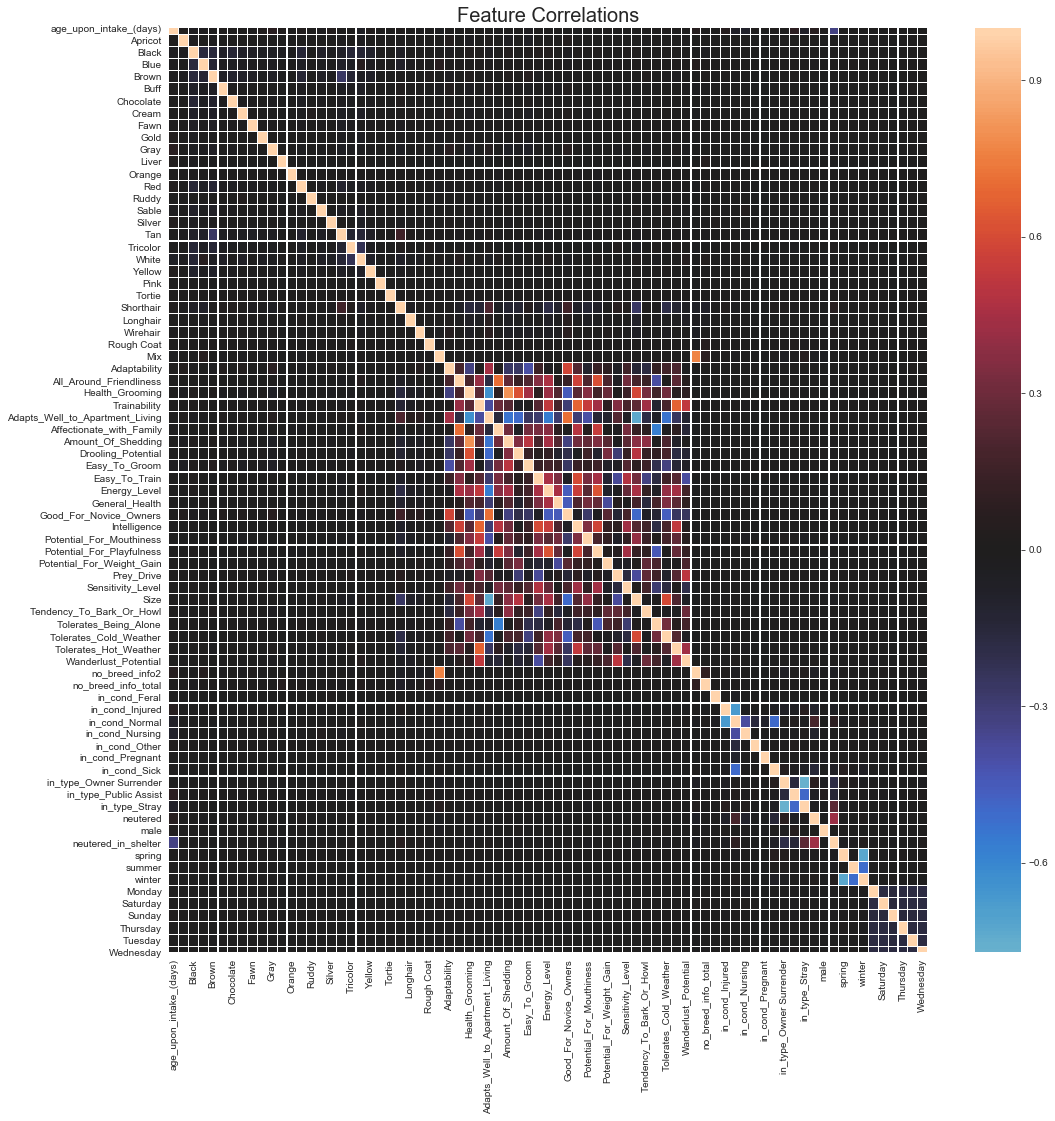

In [408]:
#look features with high correlations to multiple features
sns.set_style('darkgrid')
fig = plt.figure(figsize=(17,17))
ax = sns.heatmap(X.corr(), center=0, linewidths=.1)
ax.set_title('Feature Correlations', fontsize=20);

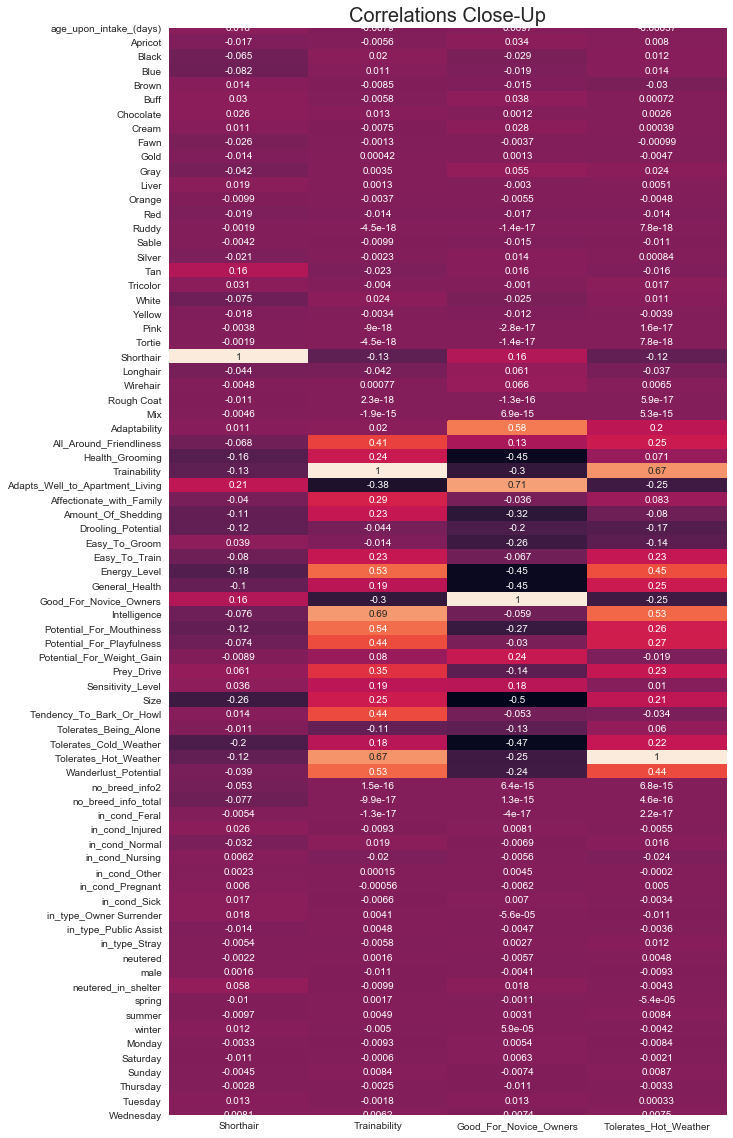

In [409]:
#Get closer look at features with potential correlation issues
plt.figure(figsize=(10,20))
sns.heatmap(annot=True, cbar=False,  data=X.corr().loc[:, X.corr().index.isin(['Shorthair', 'Trainability', 'Good_For_Novice_Owners', 'in_type_Owner_Surrender', 
                                 'Tolerates_Hot_Weather']) ])
plt.title("Correlations Close-Up", fontsize=20);

We could drop Shorthair but let's keep it until we do algorithmic feature selection.

### Look at variable distributions

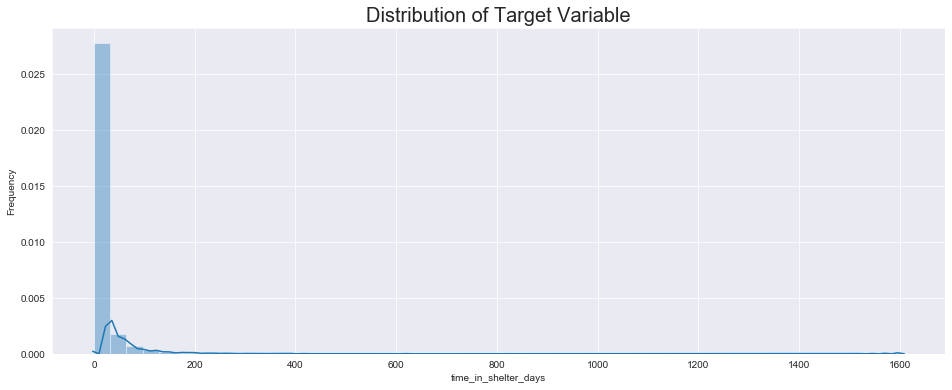

In [410]:
plt.figure(figsize=(16, 6))
ax = sns.distplot(y_train)
plt.title('Distribution of Target Variable', fontsize=20)
ax.set_ylabel('Frequency');

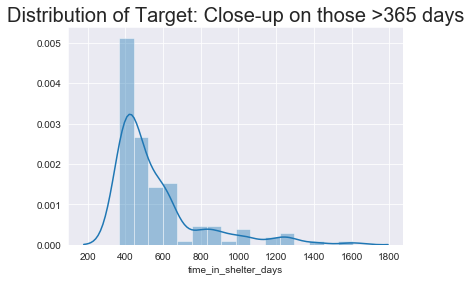

In [411]:
sns.distplot(shelter_inout_wbreeds_df.time_in_shelter_days[shelter_inout_wbreeds_df.time_in_shelter_days >365])
plt.title('Distribution of Target: Close-up on those >365 days', fontsize=20)
ax.set_ylabel('Frequency');

This is quite skewed, and apparently some dogs remain in the shelter for over 4 years! I will eliminate any observations exceeding 1 year: this is a small subset that should probably be considered separately to look at the specific issues.

In [416]:
y_drop_index = y<=365
y = y[y_drop_index]
X = X[y_drop_index]

In [417]:
#Apply boxcox transform for linear models
shift = .1
y_train_transform = pd.Series(y_train) + shift # put in series so can add to each element
y_test_transform = pd.Series(y_test) + shift
y_transform = pd.Series(y) + shift
#bc transform
y_train_transform, y_train_bc = boxcox(y_train_transform) 
y_test_transform = boxcox(y_test_transform, lmbda=y_train_bc) # use lambda from training data
y_transform = boxcox(y_transform, lmbda=y_train_bc)

In [418]:
#create function to store data used to do boxcox transform so it can be reversed later
def reverse_bc(y, lmbda=y_train_bc):
    y = inv_boxcox(y, lmbda=lmbda)
    y -= shift
    return y

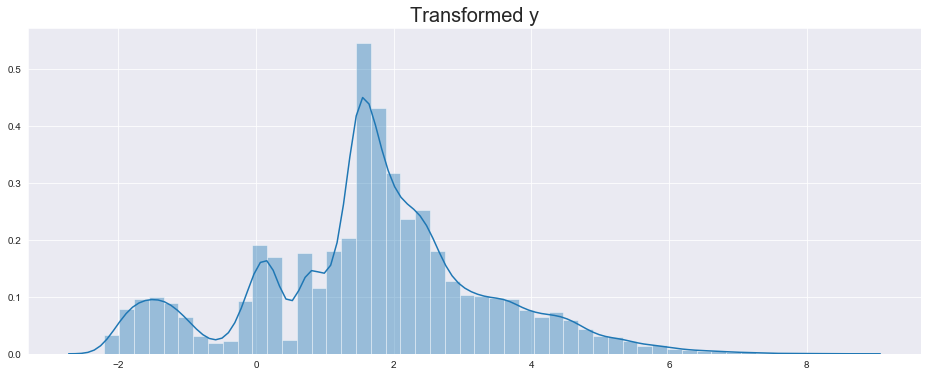

In [419]:
plt.figure(figsize=(16, 6))
sns.distplot(y_train_transform)
plt.title("Transformed y", fontsize=20);

This is not a normal distribution but much improved.

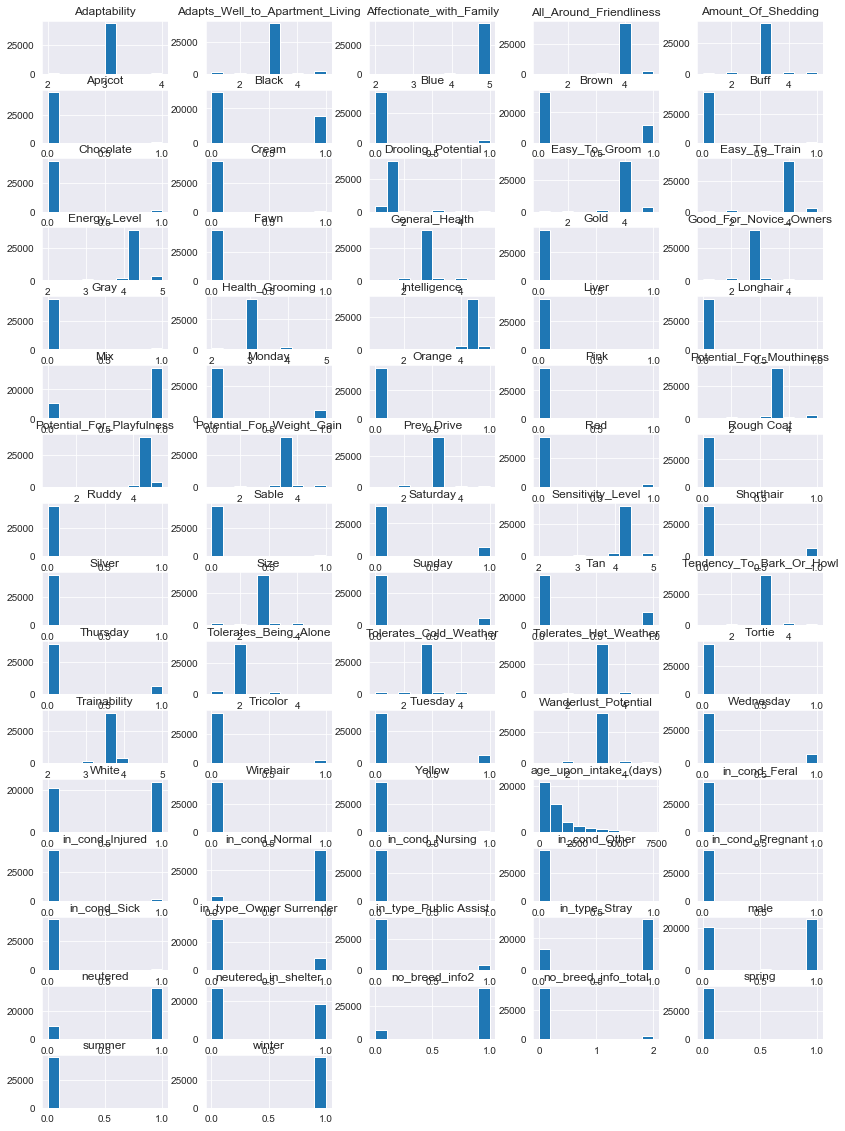

In [420]:
#Plot feature distributions
X.hist(layout=(-1,5), figsize=(14,20));    

## Feature Selection
To narrow down the features I will perform a Boruta feature elimination to find a set of features to test various models on. I need an initial model to use as a parameter in the Boruta algorithm, and will do a random search to find a satisfactory model.

In [ ]:
#Define search parameters and perform random search to find best params
rforest_params = {'criterion': ('mse', 'mae'),
                 'max_features': ('log2', 'sqrt', .2, .15),  
                 'max_depth': (5, 15, 30),
                 'min_samples_split': (10, 20, 30)}  

rforest = RandomForestRegressor(n_estimators=30, verbose=0, n_jobs=-1, oob_score=False, bootstrap=True)
random_forest_best = RandomizedSearchCV(estimator=rforest, n_iter=20, n_jobs=-1, param_distributions=rforest_params, cv=3)
random_forest_best.fit(X_train, y_train_transform)

In [431]:
#use best hypers from model search.
random_forest_best = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [422]:
# use Bourta feature elimination to get alternative list of features to use
boruta_est_cnt = 30
boruta_selector_more = BorutaPy(random_forest_best, n_estimators=boruta_est_cnt, verbose=0, perc=50)
boruta_selector_more.fit(X_train.values, y_train)  #Boruta only accepts np arrays

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                         max_depth=15, max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=20,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=30, n_jobs=-1,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x000001FBC14879F8>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators=30, perc=50,
         random_state=<mtrand.RandomState object at 0x000001FBC14879F8>,
         two_

In [423]:
boruta_selector_fewer = BorutaPy(random_forest_best, n_estimators=boruta_est_cnt, verbose=0, perc=100)
boruta_selector_fewer.fit(X_train.values, y_train)  #Boruta only accepts np arrays

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                         max_depth=15, max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=20,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=30, n_jobs=-1,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x000001FBC14879F8>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators=30, perc=100,
         random_state=<mtrand.RandomState object at 0x000001FBC14879F8>,
         two

In [424]:
print("Number of features Selected by Bourta Alg: More: {}, fewer: {}"\
      .format(boruta_selector_more.n_features_, boruta_selector_fewer.n_features_))
print("Selected Features (More): {}".format(X_train.columns[boruta_selector_more.support_]))
print("Selected Features (Fewer): {}".format(X_train.columns[boruta_selector_fewer.support_]))

Number of features Selected by Bourta Alg: More: 17, fewer: 1
Selected Features (More): Index(['age_upon_intake_(days)', 'Blue', 'Red', 'Tan', 'White', 'Shorthair',
       'General_Health', 'Prey_Drive', 'no_breed_info_total',
       'in_cond_Injured', 'in_cond_Normal', 'in_cond_Other',
       'in_type_Owner Surrender', 'neutered', 'neutered_in_shelter', 'Tuesday',
       'Wednesday'],
      dtype='object')
Selected Features (Fewer): Index(['age_upon_intake_(days)'], dtype='object')


In [425]:
# Create new X with reducted feature set
X_train_red = X_train.loc[:,X_train.columns[boruta_selector_more.support_]]
X_test_red = X_test.loc[:,X_test.columns[boruta_selector_more.support_]]
X_red = X.loc[:,X.columns[boruta_selector_more.support_]]
X_train_red_fewer = X_train.loc[:,X_train.columns[boruta_selector_more.support_]]
X_test_red_fewer = X_test.loc[:,X_test.columns[boruta_selector_more.support_]]

In [395]:
random_forest_best_fewer = clone(random_forest_best)

In [398]:
#compare scores for different levels of retained features
rf_cv_score_more_features = cross_val_score(estimator=random_forest_best, X=X_train_red, y=y_train_transform, cv=3, n_jobs=-1)
rf_cv_score_fewer_features = cross_val_score(estimator=random_forest_best_fewer, X=X_train_red_fewer, y=y_train_transform, cv=3, n_jobs=-1)
print("Score with More features retained: {}".format(rf_cv_score_more_features))
print("Score with fewer features retained: {}".format(rf_cv_score_fewer_features))

Score with More features retained: [0.2183222  0.21045506 0.21945427]
Score with fewer features retained: [0.2183222  0.21045506 0.21945427]


The scores are almost the same when using the highly reduced features set. 

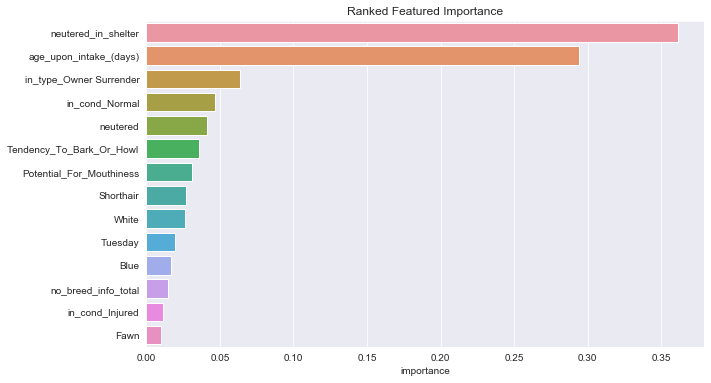

In [400]:
#review feature importance of selected features
random_forest_best.fit(X_train_red, y_train_transform)
reduced_features = X_train.columns[boruta_selector_more.support_].to_list()
important_features = pd.DataFrame(data=random_forest_best.feature_importances_, index=reduced_features)
important_features.columns = ['importance']
important_features.sort_values(by='importance', ascending=False,inplace=True)
figimp = plt.figure(figsize=(10,6))
aximp = sns.barplot(y=important_features.index, x=important_features['importance'], orient='h')
aximp.set(title='Ranked Featured Importance');

## Modeling

### Linear Regression
We will first try a linear regression since that has the advantage of speed, and explainability if it works well.  
We will use a random search to find the best hyperparameters.  
Models with regularization needs standardized data. Since most data is from OHE, we will use minmax.

In [434]:
X_train_red_stand =  MinMaxScaler(feature_range=(0,1)).fit_transform(X_train_red)

In [435]:
params = {'alpha': stats.uniform(.0001, 100),
         'l1_ratio': stats.uniform(.1, .9)}
enet = ElasticNet()
enet_rsearch = RandomizedSearchCV(estimator=enet, param_distributions=params, n_iter=12, cv=5)
#enet_rsearch.fit(X_train, y_train)
nested_scores = cross_validate(estimator=enet_rsearch, X=X_train_red_stand, y=y_train_transform, cv=4, n_jobs=-1, 
                               return_estimator=True)
print('Test scores are: {}'.format(nested_scores['test_score']))

Test scores are: [-9.71873357e-04 -3.04640063e-04 -1.14484610e-05 -2.95426672e-04]


### Tree Models
There may be a number of interactions, so forest-based models may be useful to improve predictive ability.

In [436]:
#define search space and set up model
rforest_params = {'criterion': ('mse', 'mae'),
                 'max_features': ('log2', 'sqrt', .2, .15),  
                 'max_depth': (5, 15, 30),
                 'min_samples_split': (10, 20, 30)}  

rforest = RandomForestRegressor(n_estimators=60, verbose=0, n_jobs=-1, oob_score=False, bootstrap=True)
rforest_rsearch = RandomizedSearchCV(estimator=rforest, param_distributions=rforest_params, n_iter=60, cv=3)

In [ ]:
#cross validate model
rf_cv_scores = cross_validate(estimator=rforest_rsearch, X=X_train_red, y=y_train_transform, n_jobs=-1, cv=3)

In [ ]:
rf_cv_scores

In [96]:
gboost_params = {'loss': ('ls', 'lad', 'huber'),
                 'subsample': (.5, .8, 1),
                 'learning_rate': (.05, .08, .1, .2, .3, .6),
                 'max_depth': (2, 3, 5, 6)}
grad_boost = GradientBoostingRegressor(n_estimators=60)
grad_boost_rs = RandomizedSearchCV(estimator=grad_boost, param_distributions=gboost_params, cv=3)
gboost_cv_score = cross_val_score(estimator=grad_boost_rs, X=X_train_red, y=y_train, n_jobs=-1, cv=3, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


In [97]:
gboost_cv_score

array([0.25601032, 0.2555434 , 0.2533967 ])

### Other Models - KNN and SVM
Since these models are still not explaining the majority of the variance, let's try some other models.

In [100]:
kn_params = {'n_neighbors': (3, 5, 7),
             'weights': ('uniform', 'distance'),
             'p': (1.5, 2, 2.5)}
knr = KNeighborsRegressor()
knr_rsear = RandomizedSearchCV(estimator=knr, param_distributions=kn_params, n_jobs=-1, n_iter=12, cv=3)
knr_cv_score = cross_val_score(estimator=grad_boost, X=X_red_stand, y=y, n_jobs=-1, cv=4, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   19.0s remaining:   19.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   19.1s finished


In [101]:
knr_cv_score

array([0.03173598, 0.05190036, 0.05865016, 0.06427502])

In [98]:
svr_params = {'C': (.4, .7, 1, 1.3, 2, 10),
              'epsilon': (.001, .01, .1), 
              'kernel': ('linear', 'poly', 'rbf')}
svr = SVR()
svr_search = RandomizedSearchCV(estimator=svr, param_distributions=svr_params, n_jobs=-1, n_iter=12, cv=3)
svr_cv_score = cross_val_score(estimator=svr_search, X=X_red_stand, y=y, n_jobs=-1, cv=3, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 35.2min finished


In [99]:
svr_cv_score

array([-0.04695284, -0.0424821 , -0.03790722])

In [88]:
#hardcoded model hypers to moot need to rerun CV search
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
model.fit(X_red, y_transform)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

# Interpretation  

We will use the Random forest model. The tree models were approximately equal in cross-validation scores.  The Nearest Neighbors model was able to add some predictive information, but less than the tree-bsed models.  
The models are able to explain about 25% of the variance in the time spent in the shelter before the dogs leave. 


### Features
The model we used does not have easily interpretable coefficients. We can look more closely at the features that are most important.
It was surprising to me that some features I anticipated being important were not amoung the highest features, such as Black - this is evidence against the existance of "Black Dog Syndrome". 

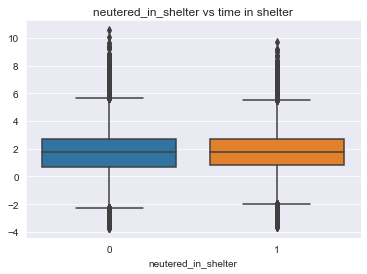

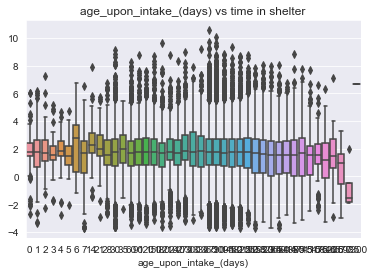

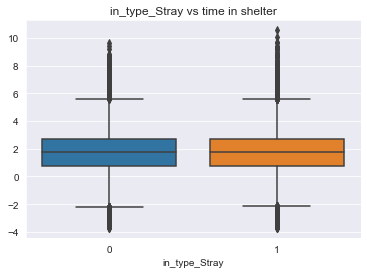

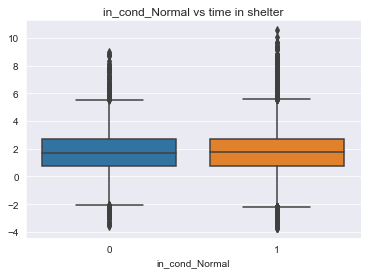

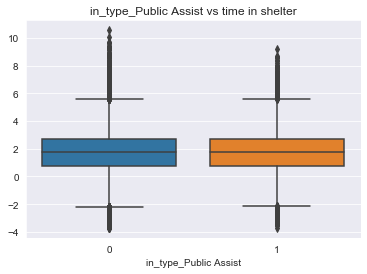

In [92]:
model_features = pd.DataFrame(data=model.feature_importances_, index=X_red.columns.to_list())
model_features.columns = ['importance']
model_features.sort_values(by='importance', ascending=False, inplace=True)
for feature, f_importance in model_features[0:5].iterrows():
    plt.figure(feature)
    sns.boxplot(x=X_red[feature], y=y_transform)
    plt.title("{} vs time in shelter".format(feature))

None of the important variables seem too directly interpretable for on impact on the outcome variable, which makes sense given the way the models performed.

### Error Distribution

In [432]:
#get predictions in original units and compare to actual
y_pred = reverse_bc(model.predict(X_red))
fig_resid = sns.scatterplot(x=y, y=y_pred, size=np.abs(y_transform-y_pred))
fig_resid.set(title="Predicted vs Actual", xlabel='Actual', ylabel='Predicted');

ValueError: Number of features of the model must match the input. Model n_features is 27 and input n_features is 17 

The residuals are indicative that the model isn't producing negative predictions. 

The results of this project indicate that while the length of the stay in the shelter is influenced by some of the recorded factors, most of the variability is caused by other factors or is random. The most important factors are whether an animal is neutered while in the shelter, the age of the animal, and whether it is a stray. 
### Further Study
Additional avenues for research would include looking out the outcome categories (such as Adoption, Return to Owner, etc. ) as a predicted variable, or looking for additional variables that might influence the amount of time the animals stay in the shelter.  
Finally, I think the lack of strong predictors of time in the shelter indicate that the Austin shelter is doing a good job of getting all of the animals to their final outcome.